In [3]:
import random
from deap import base, creator, tools, algorithms
import pandas as pd
import numpy as np
import functools
import random

1. only 11 players would be playing, and recieve points for the team, 4 would be on the bench
2. I want you to keep in mind the upcoming games, I have assigned variables difficulty rating of the upcoming 5 gameweeks using a range of 0 to 3, where 0 is easy, 3 is very hard
3. you can only have a maximum of 3 players from one team in the 15 man squad
4. each captain earns double the points for the gameweek, for eg. Haaland scored 8 points in the match, a person who has captained him will get 16 points for him
5. if the Captain does not play a signle minute, then the vice captain becomes the captain and gets double the points
6. if one of the players in the starting 11 do not play any minutes, they get replaced by someone on the bench
7.  at any given point, each team must have a minimum of 1 goalkeeper, 3 defenders, 3 midfielders and 1 attackers, this is also applicable when substitutions take place
8.  the positions are defined like this: FWD - Attacker, MID = midfielder, DEF = defender, GK = goalkeeper
9. the final output should be the ideal team with the bench and also who the captain is and the vice captain is, I also want you to give me the first naame and last name of the starting 11 and the bench
10. these are the possible formations for the starting 11:   3-4-3, 3-5-2, 4-4-2, 4-3-3, 4-5-1, 5-4-1, 5-3-2, format: defender-midfielder-attacker
11. the most important factors to be considered are: total points, form, difficulty of upcoming matches, ICT index, selection %
12. Also ensure the maximum of the 100 budget is used

In [5]:

df_updated = pd.read_csv(r"C:\Users\ASUS\Desktop\AAI project\AAI-Dataset.csv", encoding='ISO-8859-1')

df_updated.info()
df_updated.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Player ID               730 non-null    int64  
 1   Name                    730 non-null    object 
 2   Last Name               730 non-null    object 
 3   Cost                    730 non-null    float64
 4   Form                    730 non-null    float64
 5   Position                730 non-null    object 
 6   Team                    730 non-null    object 
 7   Selection %             730 non-null    float64
 8   Goals                   730 non-null    int64  
 9   Assists                 730 non-null    int64  
 10  Clean Sheets            730 non-null    int64  
 11  GW Points               730 non-null    int64  
 12  Total Points            730 non-null    int64  
 13  Points/Game             730 non-null    float64
 14  Total Bonus Points      730 non-null    in

Player ID     Name     Last Name  Cost  Form Position     Team  \
0          1  Folarin       Balogun   4.4   0.0      FWD  Arsenal   
1          2   Cédric        Cédric   3.9   0.0      DEF  Arsenal   
2          3  Mohamed      M.Elneny   4.4   0.0      MID  Arsenal   
3          4    Fábio  Fábio Vieira   5.4   0.5      MID  Arsenal   
4          5  Gabriel       Gabriel   4.7   4.0      DEF  Arsenal   

   Selection %  Goals  Assists  ...     GW13     GW14     GW15  \
0          0.3      0        0  ...  BRE (A)  WOL (H)  LUT (A)   
1          0.4      0        0  ...  BRE (A)  WOL (H)  LUT (A)   
2          0.1      0        0  ...  BRE (A)  WOL (H)  LUT (A)   
3          0.1      0        3  ...  BRE (A)  WOL (H)  LUT (A)   
4         13.2      0        0  ...  BRE (A)  WOL (H)  LUT (A)   

   Difficulty Score  GW10 Difficulty Rating  GW11 Difficulty Rating  \
0                13                       0                       2   
1                13                       0                       2   
2                13                       0                       2   
3                13                       0                       2   
4                13                       0                       2   

   GW12 Difficulty Rating  GW13 Difficulty Rating  GW14 Difficulty Rating  \
0                       0                       1                       0   
1                       0                       1                       0   
2                       0                       1                       0   
3                       0                       1                       0   
4                       0                       1                       0   

   GW15 Difficulty Rating  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  

[5 rows x 45 columns]

# Greedy Algorithm

In [6]:
def calculate_player_score(row):
    """
    Calculate a custom score for each player based on various factors such as
    total points, form, and the difficulty of upcoming matches.
    """
    difficulty_factor = sum(row[f'GW{i} Difficulty Rating'] for i in range(10, 16))
    return (row['Total Points'] + row['Form'] * 5) / (row['Cost'] * (1 + difficulty_factor / 15))

def select_best_team(df, budget=100, max_same_team=3):
    """
    Select the best team using a greedy algorithm.
    """
    df['Score'] = df.apply(calculate_player_score, axis=1)
    df_sorted = df.sort_values(by='Score', ascending=False)
    
    selected_team = []
    positions = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
    team_count = {}
    total_cost = 0
    
    for _, row in df_sorted.iterrows():
        position = row['Position']
        team = row['Team']
        cost = row['Cost']
        
        if total_cost + cost > budget:
            continue
        
        if position == 'GK' and positions[position] >= 2:
            continue
        
        if position != 'GK' and positions[position] >= 5:
            continue
        
        if team in team_count and team_count[team] >= max_same_team:
            continue
        
        selected_team.append(row)
        positions[position] += 1
        total_cost += cost
        team_count[team] = team_count.get(team, 0) + 1
        
        if len(selected_team) == 15:
            break
    
    return pd.DataFrame(selected_team)

best_team_df = select_best_team(df_updated)

best_team_df[['Name', 'Last Name', 'Position', 'Team', 'Cost', 'Total Points', 'Form']]


Name     Last Name Position            Team  Cost  Total Points  \
265       Joachim      Andersen      DEF  Crystal Palace   4.9            51   
275           Sam     Johnstone       GK  Crystal Palace   4.5            39   
534        Kieran      Trippier      DEF       Newcastle   6.9            59   
57          Ollie       Watkins      FWD     Aston Villa   8.3            70   
273          Marc         Guéhi      DEF  Crystal Palace   4.5            35   
41   Douglas Luiz  Douglas Luiz      MID     Aston Villa   5.5            49   
23       Benjamin         White      DEF         Arsenal   5.6            45   
663         Micky    Van de Ven      DEF           Spurs   4.6            40   
708         Hwang      Hee Chan      MID          Wolves   5.4            42   
672        Jarrod         Bowen      MID        West Ham   7.4            58   
516       Anthony        Gordon      MID       Newcastle   5.6            45   
117       Mathias        Jensen      MID       Brentford   5.5            48   
670      Alphonse        Areola       GK        West Ham   4.2            34   
185          Lyle        Foster      FWD         Burnley   5.0            33   
439        Julián     J.Alvarez      FWD        Man City   7.1            57   

     Form  
265   7.0  
275   6.3  
534  11.5  
57   12.0  
273   5.3  
41    6.8  
23    6.8  
663   6.0  
708   7.3  
672   6.5  
516   6.2  
117   6.0  
670   2.5  
185   4.0  
439   6.3

In [10]:
def select_best_starting_eleven(df):
    formations = [(1,3, 4, 3), (1,3, 5, 2), (1,4, 4, 2), (1,4, 3, 3), (1,4, 5, 1), (1,5, 4, 1), (1,5, 3, 2)]

    df_updated['Score'] = df_updated.apply(calculate_player_score, axis=1)
    best_score = -1
    best_starting_eleven = None
    best_formation = None
    
    for formation in formations:
        goalkeepers = df[df['Position'] == 'GK'].nlargest(formation[0], 'Score')
        defenders = df[df['Position'] == 'DEF'].nlargest(formation[1], 'Score')
        midfielders = df[df['Position'] == 'MID'].nlargest(formation[2], 'Score')
        forwards = df[df['Position'] == 'FWD'].nlargest(formation[3], 'Score')
        
        starting_eleven = pd.concat([goalkeepers, defenders, midfielders, forwards])
        
        total_score = starting_eleven['Score'].sum()
        
        if total_score > best_score:
            best_score = total_score
            best_starting_eleven = starting_eleven
            best_formation = formation
    
    return best_starting_eleven, best_formation

best_starting_eleven, best_formation = select_best_starting_eleven(best_team_df)

print(f"Best Formation: {best_formation}")
print("Best Starting Eleven:")
print(best_starting_eleven[['Name', 'Last Name', 'Position', 'Score']])

def select_captain_and_vice_captain(starting_eleven):
    # Sort the starting eleven by score
    starting_eleven = starting_eleven.sort_values(by='Score', ascending=False)
    
    # Select captain and vice-captain
    captain = starting_eleven.iloc[0]
    vice_captain = starting_eleven.iloc[1]
    
    return captain, vice_captain
captain, vice_captain = select_captain_and_vice_captain(best_starting_eleven)
print(f"captain: {captain['Name']} {captain['Last Name']}")
print(f"vice-captain: {vice_captain['Name']} {vice_captain['Last Name']}")

Best Formation: (1, 5, 4, 1)
Best Starting Eleven:
             Name     Last Name Position      Score
275           Sam     Johnstone       GK  13.823529
265       Joachim      Andersen      DEF  15.486194
534        Kieran      Trippier      DEF  13.329519
273          Marc         Guéhi      DEF  12.058824
23       Benjamin         White      DEF  11.755952
663         Micky    Van de Ven      DEF  11.413043
41   Douglas Luiz  Douglas Luiz      MID  11.913876
708         Hwang      Hee Chan      MID  10.902778
672        Jarrod         Bowen      MID  10.790938
516       Anthony        Gordon      MID  10.714286
57          Ollie       Watkins      FWD  12.365250
captain: Joachim Andersen
vice-captain: Sam Johnstone


In [9]:
df = pd.read_csv(r"C:\Users\ASUS\Desktop\AAI project\AAI-Dataset.csv", encoding='ISO-8859-1')


In [11]:
def calculate_player_score(player):
    # Define weights
    weight_total_points = 1
    weight_form = 1
    weight_difficulty = -1
    weight_ict_index = 1
    weight_selection_percentage = 1
    
    difficulty_sum = sum([
        player['GW10 Difficulty Rating'],
        player['GW11 Difficulty Rating'],
        player['GW12 Difficulty Rating'],
        player['GW13 Difficulty Rating'],
        player['GW14 Difficulty Rating']
    ])
    
    score = (weight_total_points * player['Total Points'] +
             weight_form * player['Form'] +
             weight_difficulty * difficulty_sum +
             weight_ict_index * player['ICT Index'] +
             weight_selection_percentage * player['Selection %'])
    
    return score

def select_best_team(df, budget=100, max_same_team=3):
    """
    Select the best team using a modified greedy algorithm.
    """
    df['Score'] = df.apply(calculate_player_score, axis=1)
    df_sorted = df.sort_values(by='Score', ascending=False)
    
    selected_team = []
    positions = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
    team_count = {}
    total_cost = 0
    
    for _, row in df_sorted.iterrows():
        if is_player_selectable(row, positions, team_count, total_cost, budget, max_same_team):
            update_team(row, selected_team, positions, team_count, total_cost)
    
    while len(selected_team) < 15:
        # Find the player with the lowest score in the selected team
        worst_player = min(selected_team, key=lambda x: x['Score'])
        selected_team.remove(worst_player)
        update_team_constraints(worst_player, positions, team_count, total_cost, remove=True)
        
        # Try to find a replacement from the remaining players
        for _, row in df_sorted.iterrows():
            if row['Score'] < worst_player['Score'] and \
               is_player_selectable(row, positions, team_count, total_cost, budget, max_same_team):
                update_team(row, selected_team, positions, team_count, total_cost)
                break
    iteration = 0
    while sum(player['Cost'] for player in selected_team) > budget:
        iteration += 1
        print(f"Iteration {iteration} - Total Cost: {sum(player['Cost'] for player in selected_team)}")
        
        # Sort the selected team by score
        selected_team.sort(key=lambda x: x['Score'])
        
        # Try to replace players from the lowest score
        for i in range(len(selected_team)):
            player_to_remove = selected_team[i]
            position_to_replace = player_to_remove['Position']
            
            # Find a replacement that is cheaper and not already in the team
            for _, player_to_add in df_sorted.iterrows():
                player_ids_in_team = [player['Player ID'] for player in selected_team]  # Assuming each player has a unique ID
                
                if player_to_add['Position'] == position_to_replace and \
                   player_to_add['Cost'] < player_to_remove['Cost'] and \
                   player_to_add['Player ID'] not in player_ids_in_team:  # Assuming each player has a unique ID
                    
                    print(f"Removing {player_to_remove['Name']} (Cost: {player_to_remove['Cost']}, Score: {player_to_remove['Score']})")
                    print(f"Adding {player_to_add['Name']} (Cost: {player_to_add['Cost']}, Score: {player_to_add['Score']})")
                    
                    # Update the team and constraints
                    update_team_constraints(player_to_remove, positions, team_count, total_cost, remove=True)
                    selected_team[i] = player_to_add  # Replace the player
                    update_team_constraints(player_to_add, positions, team_count, total_cost)
                    
                    # Break as we made a replacement
                    break
            
            # Check if the total cost is within the budget, then stop replacing
            if sum(player['Cost'] for player in selected_team) <= budget:
                break
    
    return pd.DataFrame(selected_team)




def is_player_selectable(player, positions, team_count, total_cost, budget, max_same_team):
    position = player['Position']
    team = player['Team']
    cost = player['Cost']
    
    # Check budget
    if total_cost + cost > budget:
        return False
    
    # Check position constraints
    position_limits = {'GK': 2, 'DEF': 5, 'MID': 5, 'FWD': 3}
    if positions[position] >= position_limits[position]:
        return False
    
    # Check team constraints
    if team in team_count and team_count[team] >= max_same_team:
        return False
    
    return True

def update_team(player, selected_team, positions, team_count, total_cost):
    selected_team.append(player)
    position = player['Position']
    team = player['Team']
    cost = player['Cost']
    
    positions[position] += 1
    team_count[team] = team_count.get(team, 0) + 1
    total_cost += cost

def update_team_constraints(player, positions, team_count, total_cost, remove=False):
    position = player['Position']
    team = player['Team']
    cost = player['Cost']
    
    if remove:
        positions[position] -= 1
        team_count[team] -= 1
        total_cost -= cost
    else:
        positions[position] += 1
        team_count[team] = team_count.get(team, 0) + 1
        total_cost += cost
selected_team = select_best_team(df, budget=100, max_same_team=3)
print(selected_team[['Name', 'Last Name', 'Position', 'Score', 'Cost']])
print(f"Total Team Cost: {selected_team['Cost'].sum()} million")  

Iteration 1 - Total Cost: 110.89999999999999
Removing Bernd (Cost: 4.7, Score: 80.5)
Adding Sam (Cost: 4.5, Score: 63.0)
Removing Cristian (Cost: 4.8, Score: 97.69999999999999)
Adding Lucas (Cost: 4.7, Score: 83.6)
Removing Alphonse (Cost: 4.2, Score: 99.5)
Adding Matt (Cost: 4.1, Score: 57.1)
Removing Benjamin (Cost: 5.6, Score: 104.19999999999999)
Adding Cristian (Cost: 4.8, Score: 97.69999999999999)
Removing Matty (Cost: 5.1, Score: 123.5)
Adding Destiny (Cost: 4.9, Score: 86.5)
Removing Joachim (Cost: 4.9, Score: 126.0)
Adding Dan (Cost: 4.7, Score: 82.30000000000001)
Removing Kaoru (Cost: 6.5, Score: 158.2)
Adding Pedro (Cost: 5.8, Score: 133.5)
Removing Julián (Cost: 7.1, Score: 166.29999999999998)
Adding Yoane (Cost: 5.9, Score: 108.80000000000001)
Removing Kieran (Cost: 6.9, Score: 190.3)
Adding Joachim (Cost: 4.9, Score: 126.0)
Removing Son (Cost: 9.5, Score: 192.5)
Adding Kaoru (Cost: 6.5, Score: 158.2)
Removing James (Cost: 8.1, Score: 201.0)
Adding Bryan (Cost: 6.7, Score: 

In [12]:
def select_best_starting_eleven(df):
    formations = [(1,3, 4, 3), (1,3, 5, 2), (1,4, 4, 2), (1,4, 3, 3), (1,4, 5, 1), (1,5, 4, 1), (1,5, 3, 2)]
    
    best_score = -1
    best_starting_eleven = None
    best_formation = None
    
    for formation in formations:
        goalkeepers = df[df['Position'] == 'GK'].nlargest(formation[0], 'Score')
        defenders = df[df['Position'] == 'DEF'].nlargest(formation[1], 'Score')
        midfielders = df[df['Position'] == 'MID'].nlargest(formation[2], 'Score')
        forwards = df[df['Position'] == 'FWD'].nlargest(formation[3], 'Score')
        
        starting_eleven = pd.concat([goalkeepers, defenders, midfielders, forwards])
        
        total_score = starting_eleven['Score'].sum()
        
        if total_score > best_score:
            best_score = total_score
            best_starting_eleven = starting_eleven
            best_formation = formation
    
    return best_starting_eleven, best_formation



def select_captain_and_vice_captain(starting_eleven):
    # Sort the starting eleven by score
    starting_eleven = starting_eleven.sort_values(by='Score', ascending=False)
    
    # Select captain and vice-captain
    captain = starting_eleven.iloc[0]
    vice_captain = starting_eleven.iloc[1]
    
    return captain, vice_captain

best_starting_eleven, best_formation = select_best_starting_eleven(selected_team)

print(f"Best Formation: {best_formation}")
print("Best Starting Eleven:")
print(best_starting_eleven[['Name', 'Last Name', 'Position', 'Score']])

captain, vice_captain = select_captain_and_vice_captain(best_starting_eleven)
print(f"Captain: {captain['Name']} {captain['Last Name']}")
print(f"Vice-Captain: {vice_captain['Name']} {vice_captain['Last Name']}")


Best Formation: (1, 3, 5, 2)
Best Starting Eleven:
         Name  Last Name Position  Score
275       Sam  Johnstone       GK   63.0
265   Joachim   Andersen      DEF  126.0
651  Cristian     Romero      DEF   97.7
659   Destiny     Udogie      DEF   86.5
380   Mohamed      Salah      MID  225.3
645     James   Maddison      MID  201.0
157     Kaoru     Mitoma      MID  158.2
119     Bryan     Mbeumo      MID  157.5
716     Pedro       Neto      MID  133.5
450    Erling    Haaland      FWD  240.4
439    Julián  J.Alvarez      FWD  166.3
Captain: Erling Haaland
Vice-Captain: Mohamed Salah


# Using Linear Programming Algorithm

In [52]:
import pandas as pd
from pulp import LpMaximize, LpProblem, LpVariable, lpSum

def create_lp_model(df):
    positions = ['GK', 'DEF', 'MID', 'FWD']
    max_players = {'GK': 2, 'DEF': 5, 'MID': 5, 'FWD': 3}
    budget_constraint = 100
    max_players_from_same_team = 3

    # Create a linear programming problem
    prob = LpProblem("FantasyTeamSelection", LpMaximize)
    
    # Create binary variables for player selection
    player_vars = {index: LpVariable(cat='Binary', name=str(index)) for index in df.index}
    
    # Objective function: maximize total score
    prob += lpSum(player_vars[index] * (2 if df.at[index, 'Position'] == 'FWD' else 1) * df.at[index, 'Total Points'] +
                  player_vars[index] * df.at[index, 'Form'] -
                  player_vars[index] * (df.at[index, 'GW10 Difficulty Rating'] +
                                        df.at[index, 'GW11 Difficulty Rating'] +
                                        df.at[index, 'GW12 Difficulty Rating'] +
                                        df.at[index, 'GW13 Difficulty Rating'] +
                                        df.at[index, 'GW14 Difficulty Rating']) +
                  player_vars[index] * df.at[index, 'ICT Index'] +
                  player_vars[index] * df.at[index, 'Selection %']
                  for index in df.index)
    
    # Constraints: maximum number of players for each position
    for pos in positions:
        prob += lpSum(player_vars[index] for index in df.index if df.at[index, 'Position'] == pos) <= max_players[pos]
    
    # Constraint: total cost must be less than or equal to the budget
    prob += lpSum(player_vars[index] * df.at[index, 'Cost'] for index in df.index) <= budget_constraint
    
    # Constraint: maximum 3 players from the same team
    teams = df['Team'].unique()
    for team in teams:
        prob += lpSum(player_vars[index] for index in df.index if df.at[index, 'Team'] == team) <= max_players_from_same_team
    
    # Constraint: Select exactly 15 players
    prob += lpSum(player_vars[index] for index in df.index) == 15
    
    # Constraint: Select exactly 2 goalkeepers
    prob += lpSum(player_vars[index] for index in df.index if df.at[index, 'Position'] == 'GK') == 2
    
    # Solve the problem
    prob.solve()
    
    # Extract selected players
    selected_indices = [index for index in df.index if player_vars[index].value() == 1]
    selected_team = df.loc[selected_indices]
    
    return selected_team

# Get the selected team using linear programming
selected_team_lp = create_lp_model(df)

# Display the selected team
print(selected_team_lp)

     Player ID          Name     Last Name  Cost  Form Position  \
17          19        Bukayo          Saka   8.5   6.8      MID   
34          36         Matty          Cash   5.1   4.0      DEF   
41          43  Douglas Luiz  Douglas Luiz   5.5   6.8      MID   
57          60         Ollie       Watkins   8.3  12.0      FWD   
119        108         Bryan        Mbeumo   6.7   6.0      MID   
157        143         Kaoru        Mitoma   6.5   4.8      MID   
265        220       Joachim      Andersen   4.9   7.0      DEF   
336        275         Bernd          Leno   4.7   1.7       GK   
439        343        Julián     J.Alvarez   7.1   6.3      FWD   
450        355        Erling       Haaland  14.0   4.0      FWD   
511        407           Dan          Burn   4.7   6.2      DEF   
534        430        Kieran      Trippier   6.9  11.5      DEF   
645        504         James      Maddison   8.1   6.5      MID   
651        511      Cristian        Romero   4.8   3.8      DE

In [54]:
def select_best_starting_eleven(df):
    formations = [(1,3, 4, 3), (1,3, 5, 2), (1,4, 4, 2), (1,4, 3, 3), (1,4, 5, 1), (1,5, 4, 1), (1,5, 3, 2)]
    
    best_score = -1
    best_starting_eleven = None
    best_formation = None
    
    for formation in formations:
        goalkeepers = df[df['Position'] == 'GK'].nlargest(formation[0], 'score')
        defenders = df[df['Position'] == 'DEF'].nlargest(formation[1], 'score')
        midfielders = df[df['Position'] == 'MID'].nlargest(formation[2], 'score')
        forwards = df[df['Position'] == 'FWD'].nlargest(formation[3], 'score')
        
        starting_eleven = pd.concat([goalkeepers, defenders, midfielders, forwards])
        
        total_score = starting_eleven['score'].sum()
        
        if total_score > best_score:
            best_score = total_score
            best_starting_eleven = starting_eleven
            best_formation = formation
    
    return best_starting_eleven, best_formation

# Example usage:
#selected_players = select_players_greedy(df)
best_starting_eleven, best_formation = select_best_starting_eleven(selected_team_lp)

print(f"Best Formation: {best_formation}")
print("Best Starting Eleven:")
print(best_starting_eleven[['Name', 'Last Name', 'Position', 'score']])

def select_captain_and_vice_captain(starting_eleven):
    # Sort the starting eleven by score
    starting_eleven = starting_eleven.sort_values(by='score', ascending=False)
    
    # Select captain and vice-captain
    captain = starting_eleven.iloc[0]
    vice_captain = starting_eleven.iloc[1]
    
    return captain, vice_captain
captain, vice_captain = select_captain_and_vice_captain(selected_team_lp)
print(f"captain: {captain['Name']} {captain['Last Name']}")
print(f"vice-captain: {vice_captain['Name']} {vice_captain['Last Name']}")

Best Formation: (1, 3, 4, 3)
Best Starting Eleven:
         Name  Last Name Position  score
670  Alphonse     Areola       GK   99.5
534    Kieran   Trippier      DEF  190.3
265   Joachim   Andersen      DEF  126.0
34      Matty       Cash      DEF  123.5
17     Bukayo       Saka      MID  202.5
645     James   Maddison      MID  201.0
157     Kaoru     Mitoma      MID  158.2
119     Bryan     Mbeumo      MID  157.5
450    Erling    Haaland      FWD  240.4
57      Ollie    Watkins      FWD  203.6
439    Julián  J.Alvarez      FWD  166.3
captain: Erling Haaland
vice-captain: Ollie Watkins


# Using Genetic Algorithm

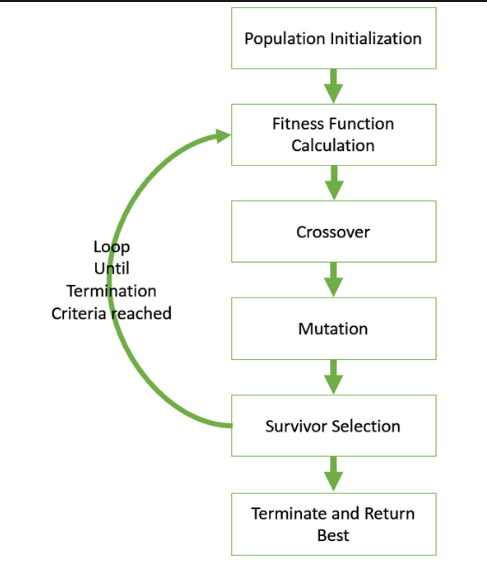

In [4]:
players_df = pd.read_csv('AAI-Dataset.csv', encoding='ISO-8859-1')

In [5]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [6]:
toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(players_df))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [7]:
def evaluate(individual, players_df, budget=100):
    team = [players_df.iloc[i] for i in range(len(individual)) if individual[i] == 1]
    
    # Constraint: Team Budget
    total_cost = sum(player['Cost'] for player in team)
    if total_cost > budget:
        return -1,  # return a negative fitness value for invalid teams
    
    # Constraint: Team Composition
    positions = ['GK', 'DEF', 'MID', 'FWD']
    max_players = {'GK': 1, 'DEF': 5, 'MID': 5, 'FWD': 3}
    for pos in positions:
        if sum(1 for player in team if player['position'] == pos) > max_players[pos]:
            return -1,  # return a negative fitness value for invalid compositions
    
    # Objective: Calculate Score
    score = sum(calculate_player_score(player) for player in team)
    
    return score,

def calculate_player_score(player):
    # Customize the weights as per your preference
    weights = {
        'total_points': 1,
        'form': 1,
        'difficulty': -0.5,
        'ict_index': 1,
        'selection_percentage': 0.1
    }
    
    difficulty = sum(player[f'GW{gw} Difficulty Rating'] for gw in range(10, 15)) / 5
    score = (weights['total_points'] * player['Total Points'] +
             weights['form'] * player['Form'] +
             weights['difficulty'] * difficulty +
             weights['ict_index'] * player['ICT Index'] +
             weights['selection_percentage'] * player['Selection %'])
    
    return score
players_df['Score'] = players_df.apply(calculate_player_score, axis=1)

In [8]:
toolbox.register("evaluate", functools.partial(evaluate, players_df=players_df))
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [9]:
population = toolbox.population(n=500)

In [10]:
n_gen = 30  # Number of generations
cxpb = 0.5  # Probability of mating two individuals
mutpb = 0.2  # Probability of mutating an individual

algorithms.eaSimple(population, toolbox, cxpb, mutpb, n_gen, stats=None, halloffame=None, verbose=True)


gen	nevals
0  	500   
1  	301   
2  	294   
3  	311   
4  	297   
5  	294   
6  	278   
7  	282   
8  	308   
9  	292   
10 	298   
11 	276   
12 	300   
13 	316   
14 	308   
15 	279   
16 	301   
17 	262   
18 	289   
19 	295   
20 	288   
21 	308   
22 	310   
23 	299   
24 	320   
25 	319   
26 	314   
27 	278   
28 	306   
29 	309   
30 	305   


([[1,
   0,
   0,
   1,
   0,
   0,
   1,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   0,
   1,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   1,
   1,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   0,
   0,
   1,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   1,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   0,
   0,
   1,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   1,
   1,
   0,
   0

In [11]:
def decode_team(individual, players_df):
    team = [players_df.iloc[i] for i in range(len(individual)) if individual[i] == 1]
    return pd.DataFrame(team)

In [20]:
def select_best_starting_eleven(team_df):
    formations = [(1,3, 4, 3), (1,3, 5, 2), (1,4, 4, 2), (1,4, 3, 3), (1,4, 5, 1), (1,5, 4, 1), (1,5, 3, 2)]
    best_score = -1
    best_starting_eleven = None
    best_formation = None
    
    for formation in formations:
        goalkeepers = team_df[team_df['Position'] == 'GK'].nlargest(formation[0], 'Score')
        defenders = team_df[team_df['Position'] == 'DEF'].nlargest(formation[1], 'Score')
        midfielders = team_df[team_df['Position'] == 'MID'].nlargest(formation[2], 'Score')
        forwards = team_df[team_df['Position'] == 'FWD'].nlargest(formation[3], 'Score')
        
        starting_eleven = pd.concat([goalkeepers, defenders, midfielders, forwards])
        total_score = starting_eleven['Score'].sum()
        
        if total_score > best_score:
            best_score = total_score
            best_starting_eleven = starting_eleven
            best_formation = formation
    
    return best_starting_eleven, best_formation


In [21]:
best_ind = tools.selBest(population, 1)[0]

In [22]:
best_team_df = decode_team(best_ind, players_df)
best_starting_eleven = select_best_starting_eleven(best_team_df)


def select_captain_and_vice_captain(starting_eleven):
    starting_eleven = starting_eleven.sort_values(by='Score', ascending=False)
    captain = starting_eleven.iloc[0]
    vice_captain = starting_eleven.iloc[1]
    return captain, vice_captain


In [23]:
# Selecting the best starting eleven
best_starting_eleven, best_formation = select_best_starting_eleven(best_team_df)


# Selecting captain and vice-captain
captain, vice_captain = select_captain_and_vice_captain(best_starting_eleven)

# Displaying the results
print(f"Captain: {captain['Name']} {captain['Last Name']}")
print(f"Vice-Captain: {vice_captain['Name']} {vice_captain['Last Name']}")
print("Best Starting Eleven:")
print(best_starting_eleven[['Name', 'Last Name', 'Position', 'Score', 'Cost']])

Captain: Mohamed Salah
Vice-Captain: Ollie Watkins
Best Starting Eleven:
         Name  Last Name Position   Score  Cost
336     Bernd       Leno       GK   71.05   4.7
265   Joachim   Andersen      DEF  111.69   4.9
23   Benjamin      White      DEF   94.66   5.6
34      Matty       Cash      DEF   94.34   5.1
380   Mohamed      Salah      MID  193.80  12.7
656       Son        Son      MID  165.23   9.5
672    Jarrod      Bowen      MID  139.96   7.4
716     Pedro       Neto      MID  128.64   5.8
57      Ollie    Watkins      FWD  172.64   8.3
450    Erling    Haaland      FWD  167.77  14.0
439    Julián  J.Alvarez      FWD  141.64   7.1
